# 7. Merged dataset (VIENNA + external collaborator cohorts) - exploratory analysis

<sub>original notebook name: `VICIS_33_revision_v4_load_prepare_final_data.ipynb`</sub>

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc

# tests for boxplots
from statannot import add_stat_annotation
# plotting configuration - set size, use high resolution
from IPython.display import set_matplotlib_formats
from matplotlib import rc_params
set_matplotlib_formats('retina')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

/var/folders/rb/y91w78gd2_sdrdl2sglwd_q91gs47h/T/ipykernel_1952/1702912842.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
input_file_preprocessed = "/Users/jreinis/OneDrive/Rotation/rotation/data_merged_final_v0/HVPG16_datasets_merged_v6_headers_updated.xlsx"

output_folder = "/Users/jreinis/OneDrive/Rotation/rotation/data_merged_final_v0/"
preprocessed_db_name = "merged_datasets_preprocessed_final_v0"
plot_folder = "/Users/jreinis/OneDrive/Rotation/rotation/HVPG16_manuscript_figures_v4_revision/"

In [3]:
# parameters we want to extract 
parameters = ["dataset", "Center-ID", "Age", "Disease_activity", "Sex", "Etiology", "STRICTLY_COMPENSATED", "Date_HVPG", "Date_LAB", 
              "HVPG", "VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR", "MELD-Score", "CHILD-Score", "Etiological_therapy", "Comment"]

# parameter names to be changed
par_name_change = {"MELD-Score": "MELD",
                   "CHILD-Score": "Child-score",
                  }

# rename Barcelona dataset names for plotting purposes (HC/HSP on newline)
rename_barcelona = {"BARCELONA-HSP": "BARCELONA\n(HSP)", "BARCELONA-HC": "BARCELONA\n(HC)"}
# order of (renamed) datasets to show
datasets_order_show = ["VIENNA", "ANTWERP", "BARCELONA\n(HC)", "BARCELONA\n(HSP)", "FRANKFURT", "MADRID", "MODENA", "PARIS"]

### Load preprocessed data in one table

In [4]:
data_raw = pd.read_excel(input_file_preprocessed, na_values="n/a")[parameters].rename(columns=par_name_change)

In [5]:
failed_date_LAB = []
failed_date_HVPG = []
for i in range(len(data_raw)):
    if str(type(data_raw.loc[i, "Date_LAB"])) == "<class 'str'>":
        failed_date_LAB.append(i)
    if str(type(data_raw.loc[i, "Date_HVPG"])) == "<class 'str'>":
        failed_date_HVPG.append(i)
data_failed_date_LAB = data_raw.loc[failed_date_LAB]
data_failed_date_HVPG = data_raw.loc[failed_date_HVPG]
print("HVPG", data_failed_date_HVPG.shape[0], data_failed_date_HVPG.dataset.unique())
print("LAB", data_failed_date_LAB.shape[0], data_failed_date_LAB.dataset.unique())

HVPG 107 ['BARCELONA-HC' 'BARCELONA-HSP']
LAB 104 ['BARCELONA-HSP']


In [6]:
# calculate how many days between HVPG and LAB measurements
data_raw['Date_HVPG'] = pd.to_datetime(data_raw['Date_HVPG'], dayfirst=True)
data_raw['Date_LAB'] = pd.to_datetime(data_raw['Date_LAB'], dayfirst=True)
data_raw["LAB_HVPG_delta"]= abs(data_raw['Date_HVPG'] - data_raw['Date_LAB'])

In [7]:
data_raw["STRICTLY_COMPENSATED"] = data_raw["STRICTLY_COMPENSATED"].str.upper()

In [8]:
print(data_raw.shape)

# filter out patients with missing HVPG measurement or not strictly compensated
data = data_raw.query('HVPG.notnull() & STRICTLY_COMPENSATED == "YES"').copy()
print(data.shape)

# filter out patients with HVPG and LAB measurements more than 180 days apart
data = data[data.LAB_HVPG_delta < pd.Timedelta(180, unit="d")].copy()
print(data.shape)

# convert time delta to days (absolute value)
data["LAB_HVPG_delta"] = data["LAB_HVPG_delta"].astype("timedelta64[D]").astype("int64")
print(data.shape)

(1233, 22)
(1233, 22)
(1232, 22)
(1232, 22)


### Round up HVPG to 0.5

In [9]:
data["HVPG_old"] = data["HVPG"]
data["HVPG"] = (data["HVPG"]*2).round()/2

In [10]:
# save as csv/xlsx
data.to_csv(output_folder+f"{preprocessed_db_name}.csv", index=None, na_rep="n/a")
data.to_excel(output_folder+f"{preprocessed_db_name}.xlsx", index=None, na_rep="n/a")

### Reload from csv (for reruns)

In [11]:
data = pd.read_csv(output_folder+f"{preprocessed_db_name}.csv")

### Calculate mean and median span between dates of HVPG and lab

In [12]:
data.LAB_HVPG_delta.mean(), data.LAB_HVPG_delta.median()

(8.146915584415584, 0.0)

### See how many measurements we have for each parameter in each dataset after filtering

In [16]:
parameters_show = ["Center-ID", "HVPG", "INR", "PLT", "BILI", "aPTT", "CHE", "GGT", "VCTE-LSM-kPa", "MELD", "Child-score"]
parameters_show_names = ["Patients", "HVPG", "INR", "PLT", "BILI", "aPTT", "CHE", "GGT", "LSM", "MELD", "Child score"]

In [17]:
data["dataset"] = data["dataset"].replace(rename_barcelona)

data['dataset'] = pd.Categorical(data['dataset'], categories=datasets_order_show, ordered=True)
counts_extended = data.groupby("dataset")[parameters_show].count()
counts_extended.loc['TOTAL']= counts_extended.sum()
percentages = counts_extended[parameters_show].div(counts_extended.HVPG, axis=0)
percentages.replace(np.nan, 0, inplace=True)

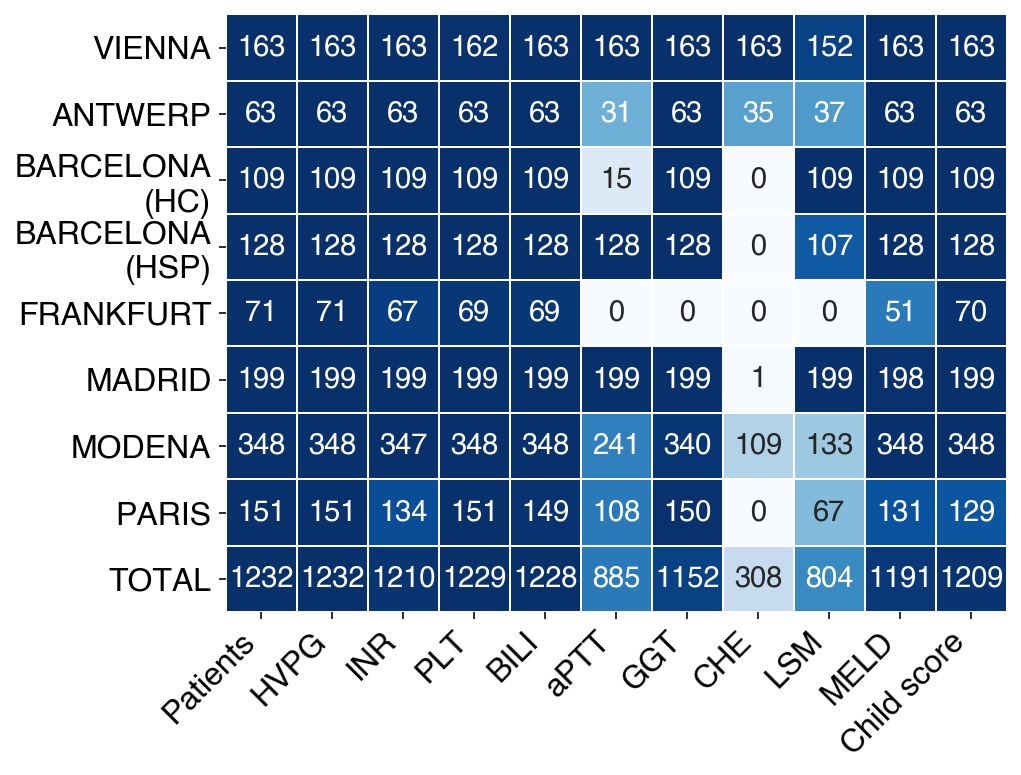

In [18]:
plt.figure(figsize=(7,5.5))
g = sns.heatmap(percentages, annot=counts_extended, fmt='g', cmap="Blues", linewidths=1, cbar=False, annot_kws={"fontsize":14.5})
g.set(ylabel=None)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
g.set_xticklabels(parameters_show_names, rotation = 45, ha="right")

plt.savefig(plot_folder+"datasets_overview.pdf", bbox_inches="tight")
plt.show()

### HVPG16: see how many high-risk patients (HVPG >= 16 or 10) we have for each dataset

In [20]:
def tweak_boxplot_narrow(a, dataset_order_labels):
    a.set_yticklabels(dataset_order_labels)
    handles, labels = a.get_legend_handles_labels()     # remove "HVPG_label" text (variable name) from the legend
    a.legend(handles=handles[:], labels=labels[:])
    a.set_ylabel(None)                                  # x/y axis labels

In [21]:
def tweak_boxplot_wide(a, dataset_order_labels):
    a.set_xticklabels(dataset_order_labels)
    handles, labels = a.get_legend_handles_labels()     # remove "HVPG_label" text (variable name) from the legend
    a.legend(handles=handles[:], labels=labels[:])
    a.set_xlabel(None)                                  # x/y axis labels

In [22]:
def label_patients_HVPG_threshold(data, cutoff):
    data[f'HVPG{cutoff}_label'] = f'HVPG < {cutoff}'
    data.loc[data.HVPG >= cutoff, f'HVPG{cutoff}_label'] = f'HVPG ≥ {cutoff}'

In [23]:
def plot_patients_HVPG_threshold(data, cutoff, dataset_order_labels, show_percent=False):
    if f'HVPG{cutoff}_label' not in data.columns:
        label_patients_HVPG_threshold(data, cutoff)
    
    plt.figure(figsize=(5.85,6.5))
    ax = sns.countplot(y = 'dataset', data = data, hue = f'HVPG{cutoff}_label', hue_order=sorted(data[f'HVPG{cutoff}_label'].unique()))

    tweak_boxplot_narrow(ax, dataset_order_labels)

    plt.xticks(fontsize=16)
    plt.xlim(0,300)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of patients", fontweight="bold", labelpad=7, fontsize=16)
    plt.legend(fontsize=15)# loc=(0.32 ,0.74))

    plt.savefig(plot_folder+f'total_numbers_strictly_compensated_HVPG{cutoff}.pdf', bbox_inches="tight")
    plt.show()

In [24]:
def plot_patients_HVPG_threshold(data, cutoff, dataset_order_labels, show_percent=False):
    
    # label = column name
    label = f'HVPG{cutoff}_label'
    print(label)
    if label not in data.columns:
        label_patients_HVPG_threshold(data, cutoff)
    
    plt.figure(figsize=(3,5))
    
    if show_percent:
        percentages_raw = data.groupby("dataset")[label].value_counts(normalize=True)
        # strings corresponding to high-risk and low-risk patients
        label_values = np.unique([x[1] for x in percentages_raw.index])
        
        percentages = {}
        for label_val in label_values:
            percentages[label_val] = pd.DataFrame(percentages_raw.loc[:,label_val].reset_index().rename(columns={label:"percentage"}))
            percentages[label_val]["label"] = label_val
        percentages = pd.concat(percentages.values())
        percentages["percentage"] = percentages["percentage"]*100
        ax = sns.barplot(data = percentages, x="percentage", y = 'dataset', hue = "label")
        plt.xlim(0,100)
        plt.xlabel("Percentage of patients", fontweight="bold", labelpad=7, fontsize=16)
    else:
        ax = sns.countplot(y = 'dataset', data = data, hue = label, hue_order=sorted(data[label].unique()))
        plt.xlim(0,300)
        plt.xlabel("Number of patients", fontweight="bold", labelpad=7, fontsize=16)

    tweak_boxplot_narrow(ax, dataset_order_labels)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=15, loc="best")
    #plt.title(f"HVPG{cutoff}", fontsize=16, fontweight="bold")

    percentage_suffix_add = {True:"_percentage", False:""}[show_percent]
    plt.savefig(plot_folder+f'total_numbers_strictly_compensated_HVPG{cutoff}{percentage_suffix_add}.pdf', bbox_inches="tight")
    plt.show()

#### HVPG >= 16

HVPG16_label


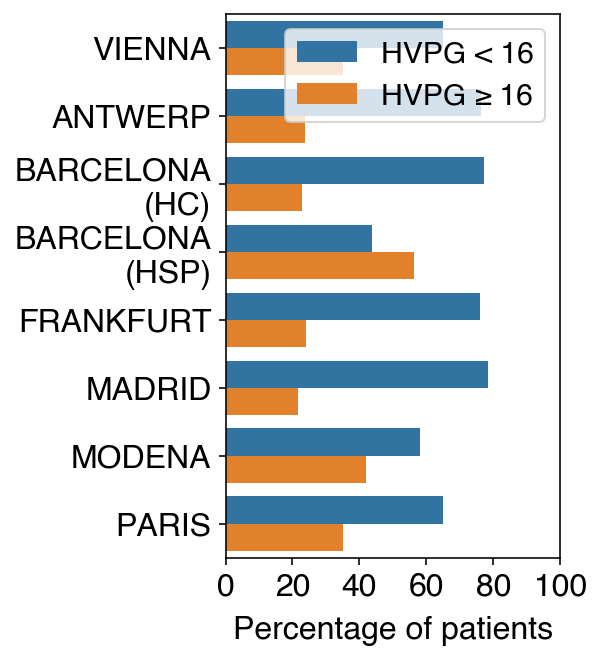

In [25]:
plot_patients_HVPG_threshold(data, 16, datasets_order_show, show_percent=True)

#### HVPG >= 10

HVPG10_label


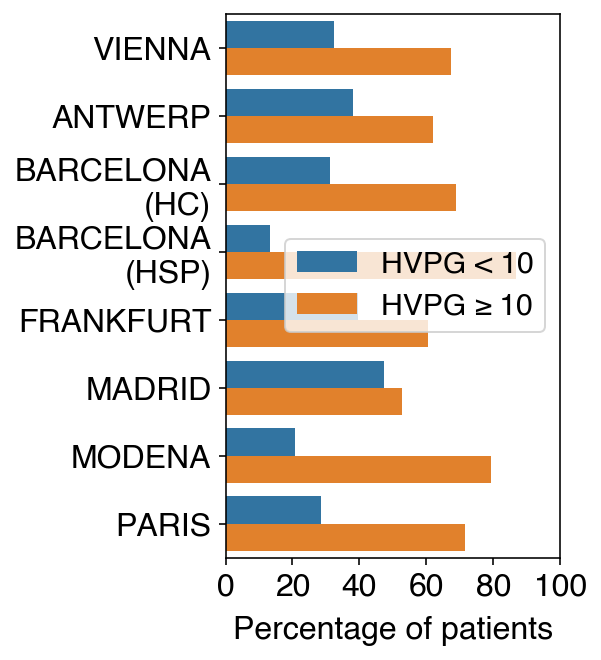

In [26]:
plot_patients_HVPG_threshold(data, 10, datasets_order_show, show_percent=True)

#### Three categories plot

In [27]:
data["HVPG_label"] = 0
data.loc[data["HVPG"] >= 10, "HVPG_label"] = 1
data.loc[data["HVPG"] >= 16, "HVPG_label"] = 2

HVPG_labels_dict = {
    0: "HVPG < 10",
    1: "10 ≤ HVPG < 16",
    2: "HVPG ≥ 16",
}

data["HVPG_label"] = [HVPG_labels_dict[x] for x in data["HVPG_label"] ]
data[["HVPG", "HVPG_label"]] 

,HVPG,HVPG_label
0,11.0,10 ≤ HVPG < 16
1,9.0,HVPG < 10
2,16.5,HVPG ≥ 16
3,12.0,10 ≤ HVPG < 16
4,11.0,10 ≤ HVPG < 16
...,...,...
1227,11.0,10 ≤ HVPG < 16
1228,6.0,HVPG < 10
1229,12.0,10 ≤ HVPG < 16
1230,6.0,HVPG < 10


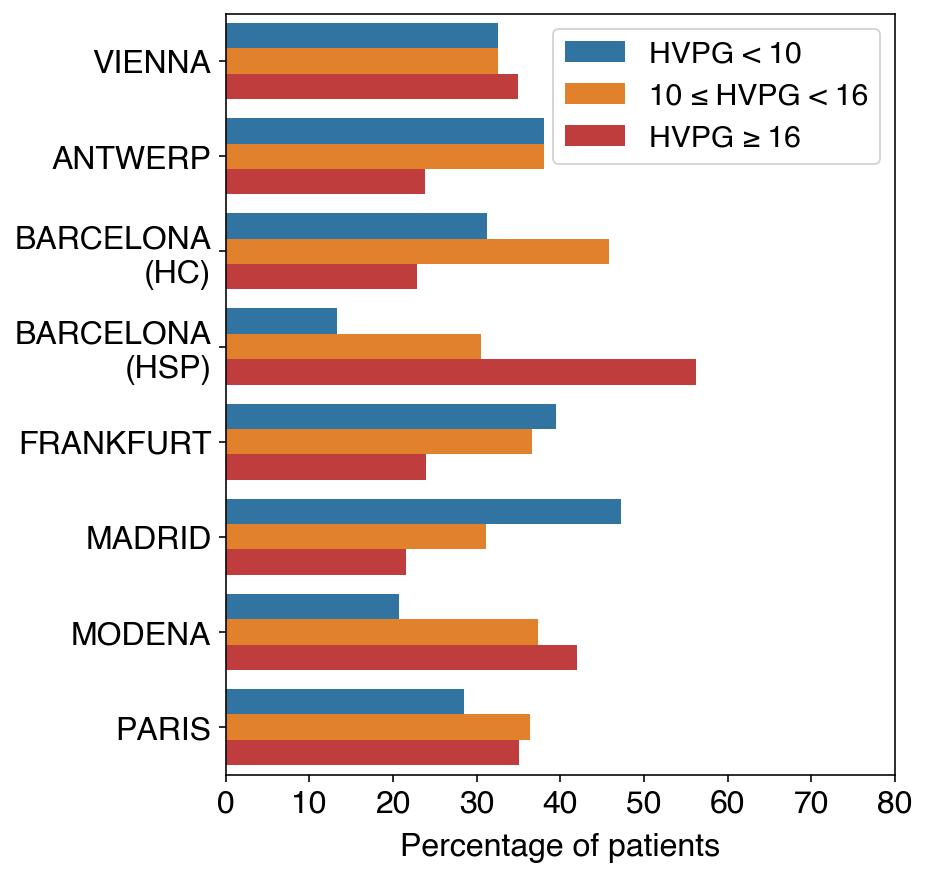

In [28]:
percentages_raw = data.groupby("dataset")["HVPG_label"].value_counts(normalize=True)
label_values = np.unique([x[1] for x in percentages_raw.index])
percentages = {}
for label_val in label_values:
    percentages[label_val] = pd.DataFrame(percentages_raw.loc[:,label_val].reset_index().rename(columns={"HVPG_label":"percentage"}))
    percentages[label_val]["label"] = label_val
percentages = pd.concat(percentages.values())
percentages["percentage"] = percentages["percentage"]*100
plt.figure(figsize=(6,7))
ax = sns.barplot(data = percentages, x="percentage", y = 'dataset', hue = "label", hue_order=["HVPG < 10", "10 ≤ HVPG < 16", "HVPG ≥ 16"], palette=np.array(sns.color_palette())[[0,1,3],:])
plt.xlim(0,80)
plt.xlabel("Percentage of patients", fontweight="bold", labelpad=7, fontsize=16)

tweak_boxplot_narrow(ax, datasets_order_show)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15, loc="best")

plt.savefig(plot_folder+f'total_numbers_strictly_compensated_HVPG_3_classes.pdf', bbox_inches="tight")
plt.show()

### Compare parameters between datasets, consider etiology

`Etiology (ALD=1; VIRAL=2; ALD+VIRAL=3;NASH=4;CHOL=5;OTHER=6)`

In [29]:
etiology_codes = {"1":"ALD",
                  "2":"VIRAL",
                  "3":"ALD+VIRAL",
                  "4":"NASH",
                  "5":"CHOL",
                  "6":"OTHER"}

In [30]:
# only accept the etiologies with the codes above
etiology_simple = pd.to_numeric(data["Etiology"], errors='coerce')
# keep only record that have only one etiology reported
data_simple_etiology = data[etiology_simple.isin(list(range(1,7)))].copy()
# change the number convention to names
data_simple_etiology = data_simple_etiology.astype("str")
data_simple_etiology.replace({"Etiology":etiology_codes}, inplace=True)

In [31]:
data_simple_etiology.query('dataset=="FRANKFURT"')

,dataset,Center-ID,Age,Disease_activity,Sex,Etiology,STRICTLY_COMPENSATED,Date_HVPG,Date_LAB,HVPG,...,INR,MELD,Child-score,Etiological_therapy,Comment,LAB_HVPG_delta,HVPG_old,HVPG16_label,HVPG10_label,HVPG_label
300,FRANKFURT,102,42,nan,1,OTHER,YES,2012-12-04,2012-12-04,6.0,...,1.2,8.0,5.0,nan,nan,0,6.0,HVPG < 16,HVPG < 10,HVPG < 10
301,FRANKFURT,109,60,nan,0,ALD,YES,2013-04-02,2013-04-02,10.5,...,1.2,10.0,5.0,nan,nan,0,10.5,HVPG < 16,HVPG ≥ 10,10 ≤ HVPG < 16
302,FRANKFURT,129,55,nan,0,ALD,YES,2013-07-09,2013-07-09,18.0,...,1.1,7.0,5.0,nan,nan,0,18.0,HVPG ≥ 16,HVPG ≥ 10,HVPG ≥ 16
303,FRANKFURT,136,56,nan,1,ALD,YES,2013-10-29,2013-10-29,12.0,...,1.2,8.0,5.0,nan,nan,0,12.0,HVPG < 16,HVPG ≥ 10,10 ≤ HVPG < 16
304,FRANKFURT,138,58,nan,1,ALD,YES,2013-11-05,2013-11-05,17.0,...,1.2,9.0,5.0,nan,nan,0,17.0,HVPG ≥ 16,HVPG ≥ 10,HVPG ≥ 16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,FRANKFURT,919,47,nan,0,CHOL,YES,2020-10-22,2020-10-22,21.0,...,1.1,nan,7.0,nan,nan,0,21.0,HVPG ≥ 16,HVPG ≥ 10,HVPG ≥ 16
367,FRANKFURT,92,55,nan,0,ALD,YES,2012-08-15,2012-08-15,17.0,...,1.3,9.0,5.0,nan,nan,0,17.0,HVPG ≥ 16,HVPG ≥ 10,HVPG ≥ 16
368,FRANKFURT,920,77,nan,1,CHOL,YES,2021-10-13,2021-10-13,15.0,...,0.9,nan,5.0,nan,nan,0,15.0,HVPG < 16,HVPG ≥ 10,10 ≤ HVPG < 16
369,FRANKFURT,97,55,nan,0,ALD,YES,2012-10-23,2012-10-23,11.0,...,1.0,6.0,5.0,nan,nan,0,11.0,HVPG < 16,HVPG ≥ 10,10 ≤ HVPG < 16


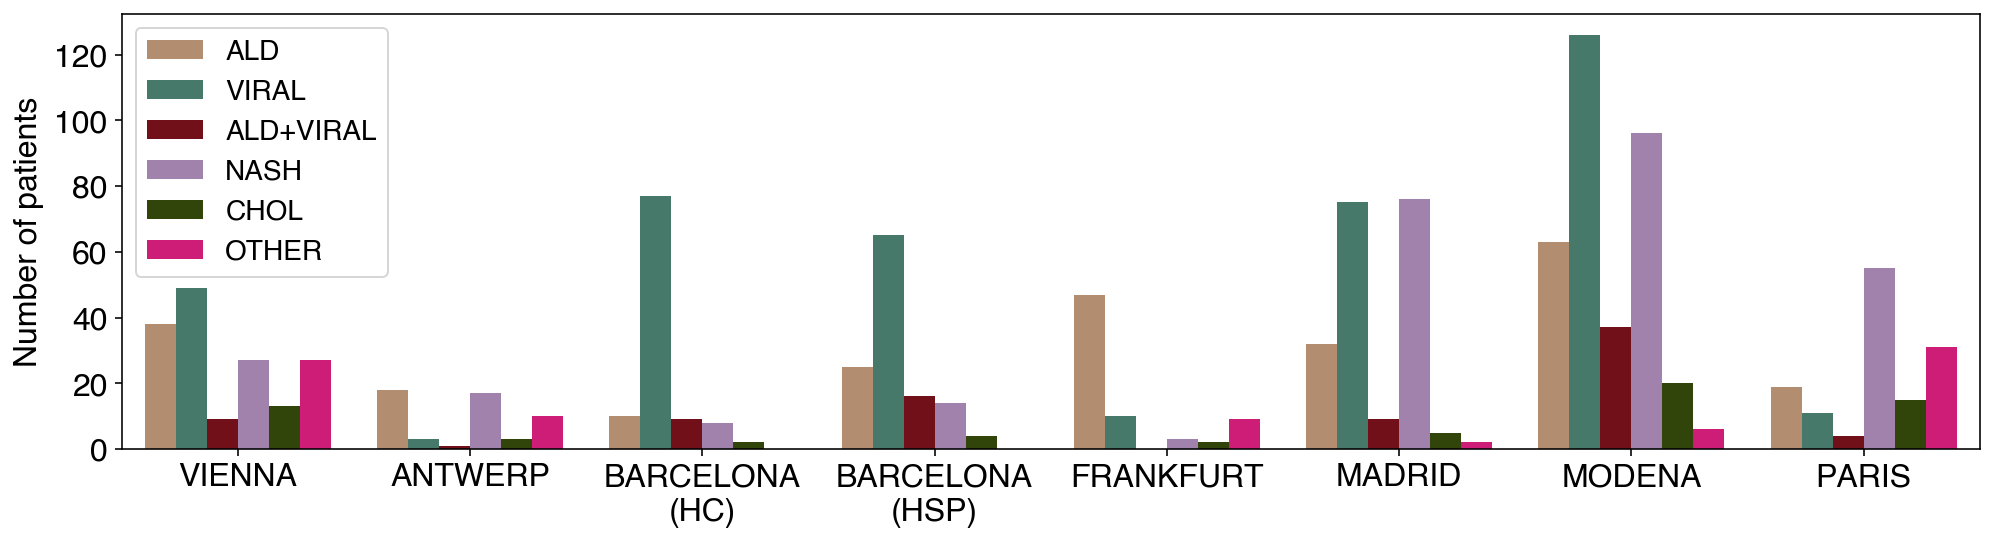

In [32]:
plt.figure(figsize=(16.65,4))
ax = sns.countplot(x = 'dataset', data = data_simple_etiology, hue = "Etiology", palette=np.array(cc.glasbey_bw)[[52,23,24,25,26,28],:], hue_order = etiology_codes.values(), order=datasets_order_show)
tweak_boxplot_wide(ax, datasets_order_show)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("Number of patients", fontweight="bold", labelpad=5, fontsize=16)
plt.legend(fontsize=14, loc=0)
plt.savefig(plot_folder+"total_numbers_strictly_compensated_etiology.pdf", bbox_inches="tight")
plt.show()

### Look at distributions of parameters, consider high/low risk (HVGP16)

In [33]:
data = data.astype({'aPTT': 'float64',
                    "VCTE-LSM-kPa": 'float64',
                    'CHE': 'float64',
                    'INR': 'float64',
                    'Child-score': 'float64'})

In [34]:
parameters_dist_show = ['VCTE-LSM-kPa', 'PLT', 'BILI', 'GGT', 'aPTT', 'CHE', 'INR', 'MELD', 'Child-score']
counts = data.groupby("dataset")[parameters_dist_show].count()

In [35]:
# MADRID has exactly one patient with CHE - therefore no test between conditions can be performed
counts.loc["MADRID", "CHE"] = 0

In [36]:
def generate_boxplots(HVPG_threshold):
    # define comparisons for statistical testing
    box_pairs = [((dataset_name, f"HVPG < {HVPG_threshold}"),(dataset_name, f"HVPG ≥ {HVPG_threshold}")) for dataset_name in datasets_order_show]
    numeric_parameters = ["VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR"]

    for parameter in numeric_parameters:
        plt.figure(figsize=(11,4))
        ax = sns.boxplot(data=data, x="dataset", y=parameter, hue=f"HVPG{HVPG_threshold}_label", showfliers = True,
                         hue_order=sorted(data[f"HVPG{HVPG_threshold}_label"].unique())) # showfliers = False not to show outliers making the the axis scale unusable
        add_stat_annotation(ax, data=data, x="dataset", y=parameter, hue=f"HVPG{HVPG_threshold}_label",
                            box_pairs=[box_pairs[i] for i,count in enumerate(counts[parameter]) if count], # test only in case there is data
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=13)

        tweak_boxplot_wide(ax, datasets_order_show)    
        plt.savefig(f"{plot_folder}/parameters_distributions/{parameter}_HVPG{HVPG_threshold}.pdf", bbox_inches="tight")
        plt.yticks(fontsize=13)
        plt.xticks(fontsize=12)
        plt.ylabel(parameter, fontsize=13)
        plt.legend(fontsize=13, loc=2)
        plt.show()    

#### HVPG16

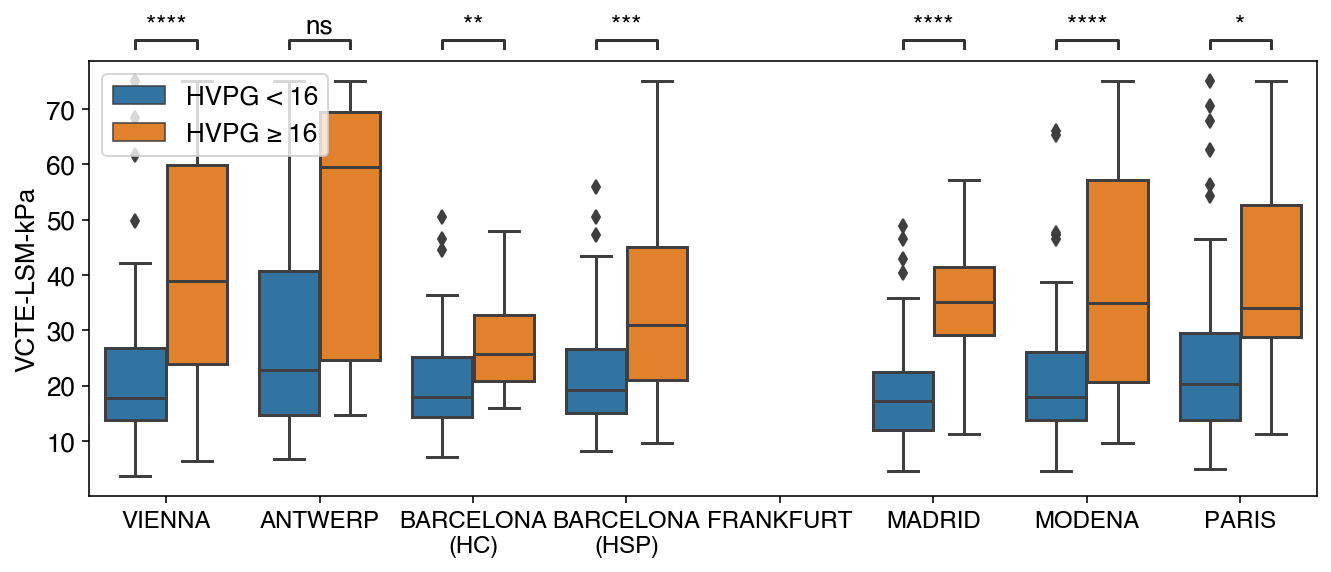

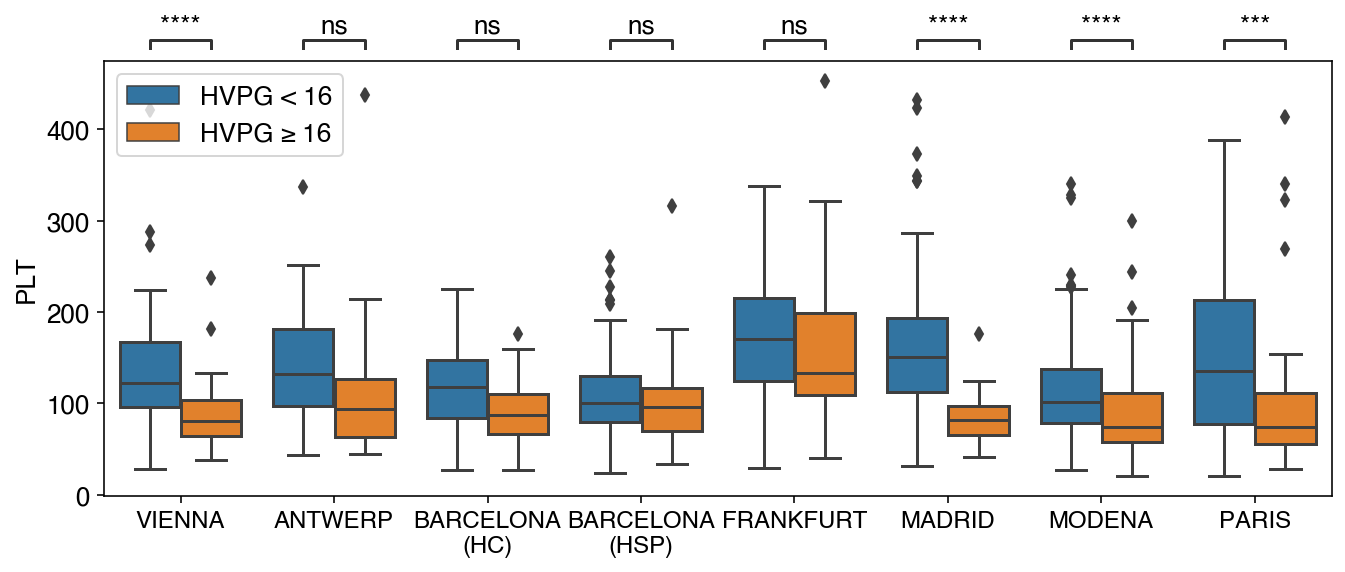

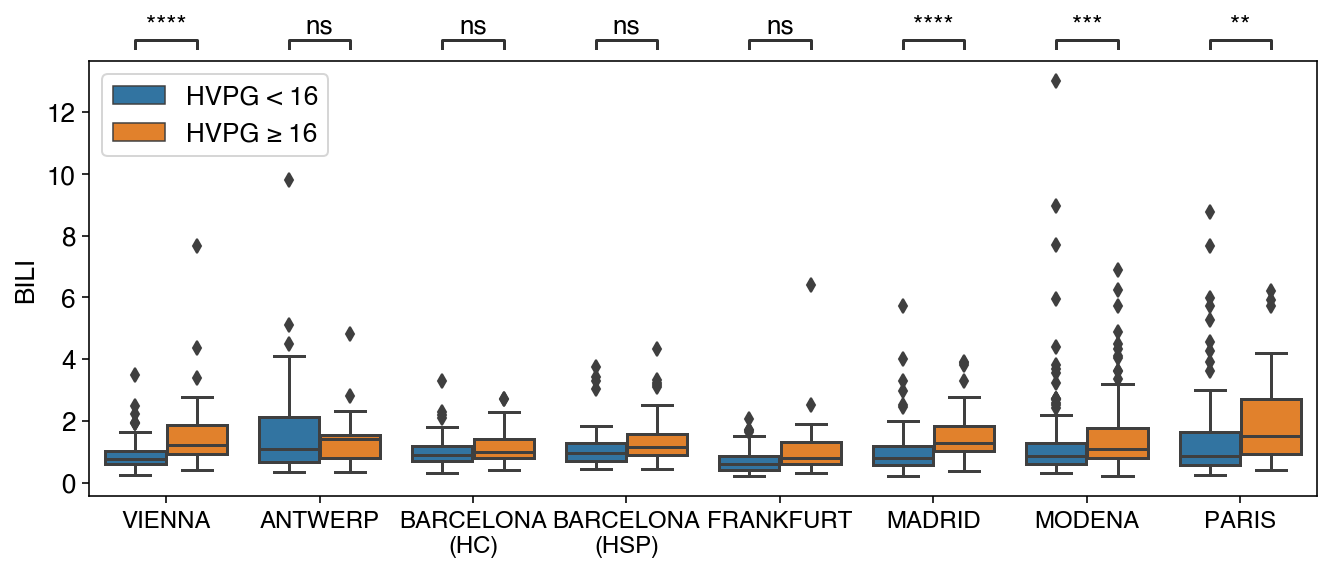

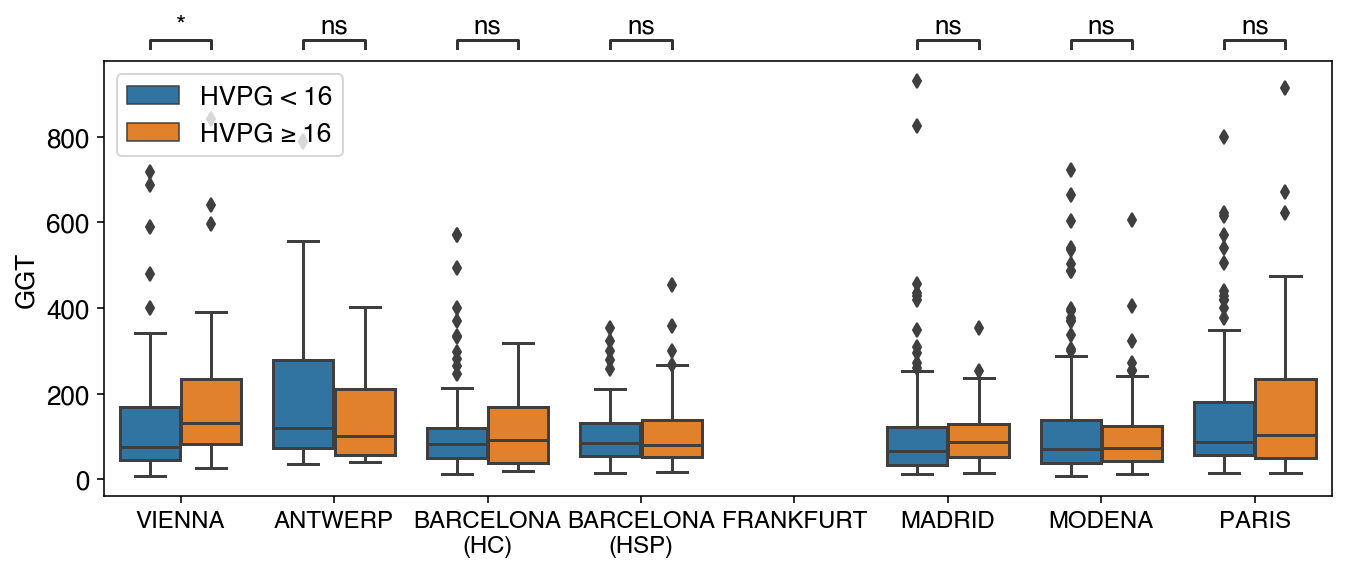

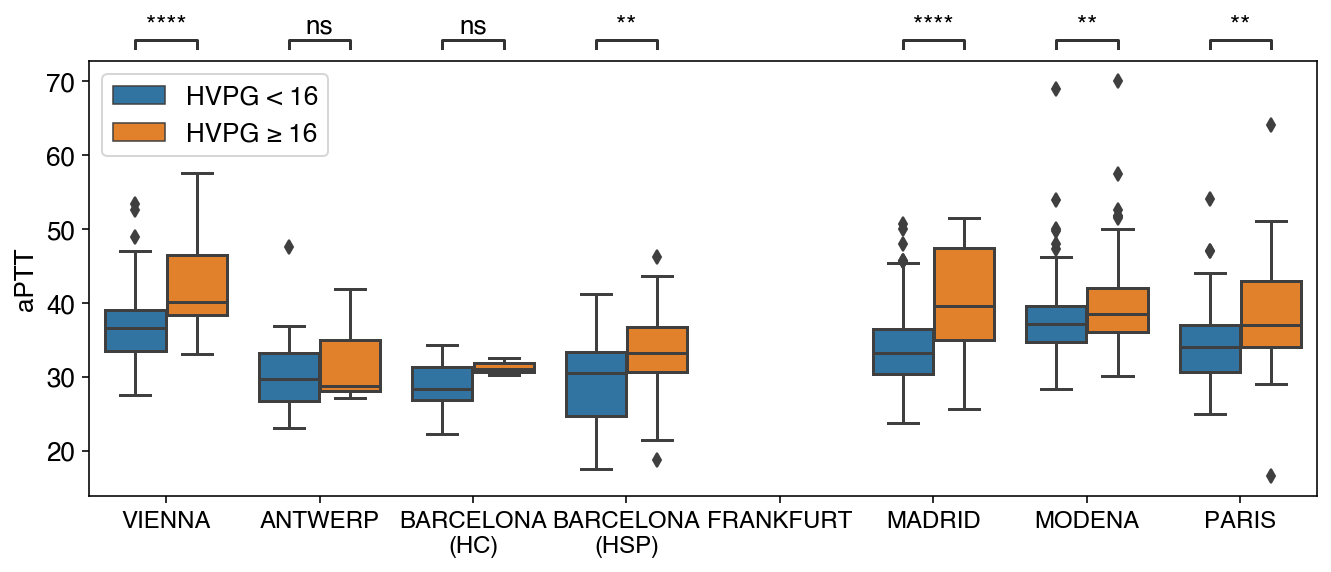

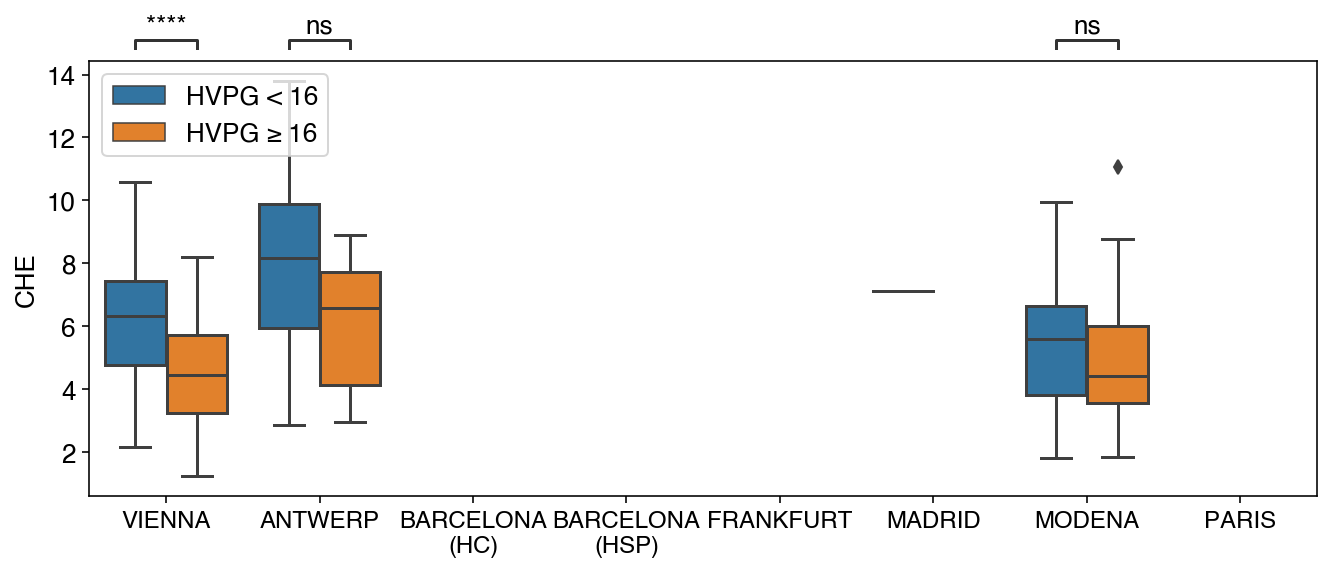

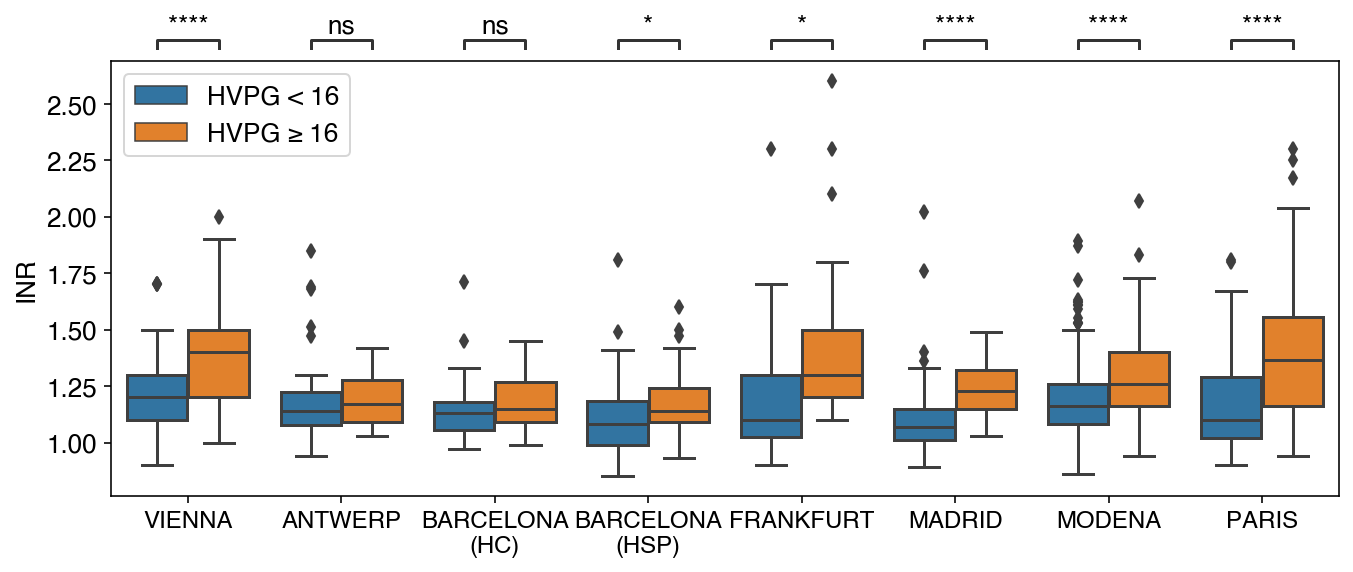

In [37]:
generate_boxplots(16)

#### HVPG10

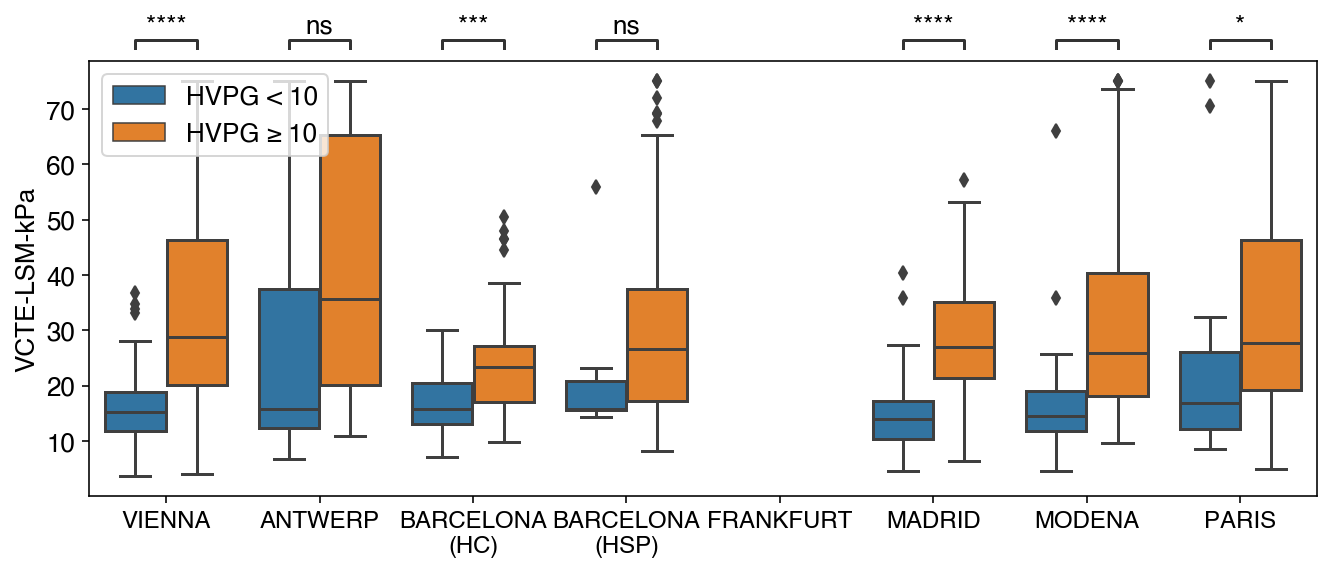

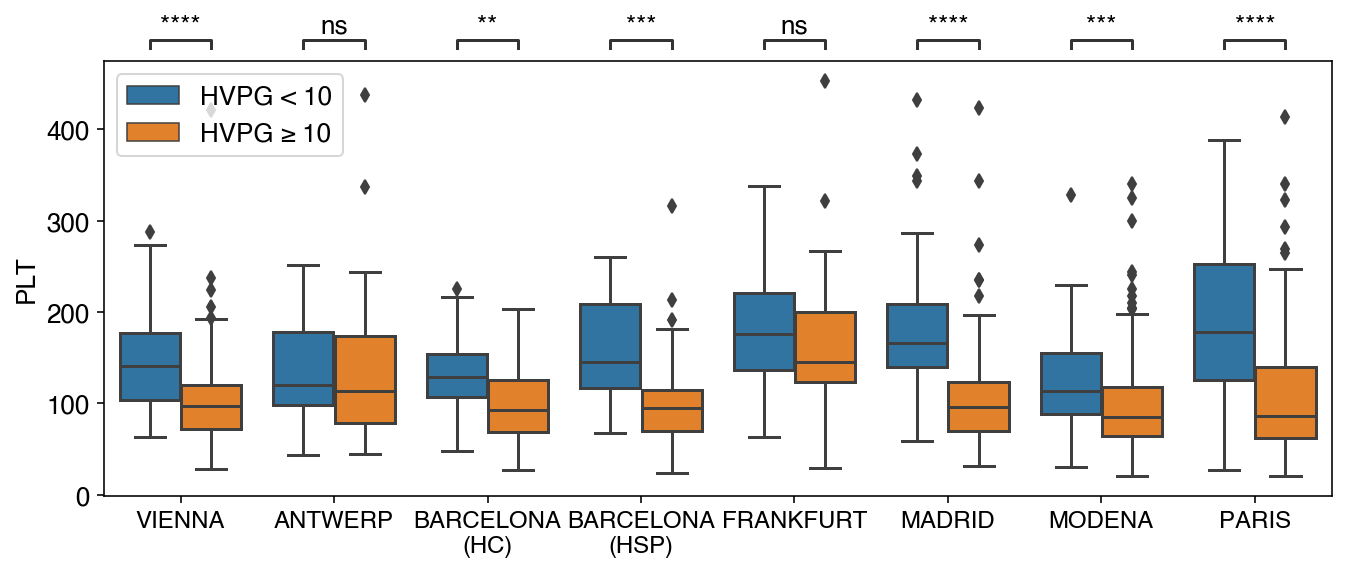

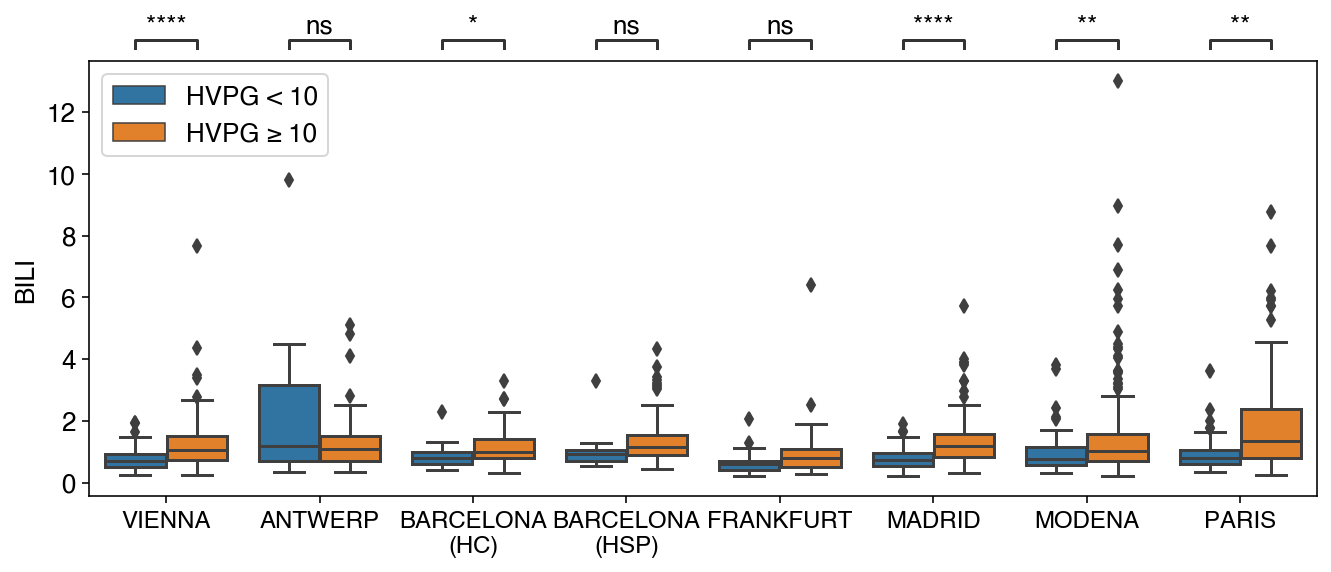

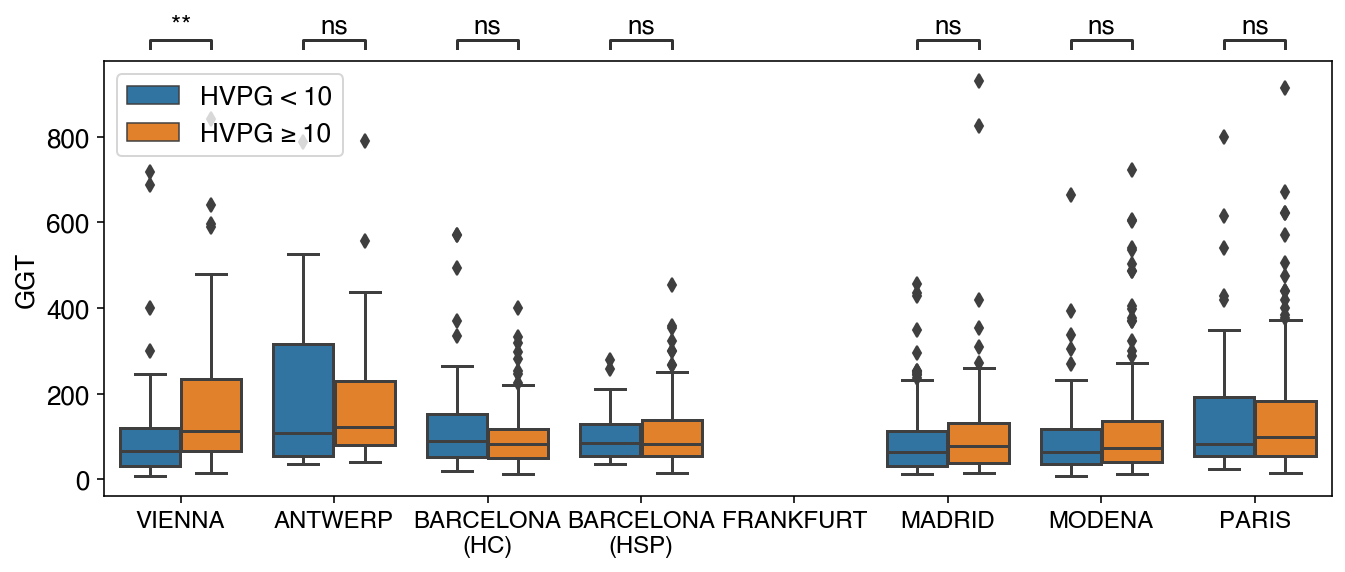

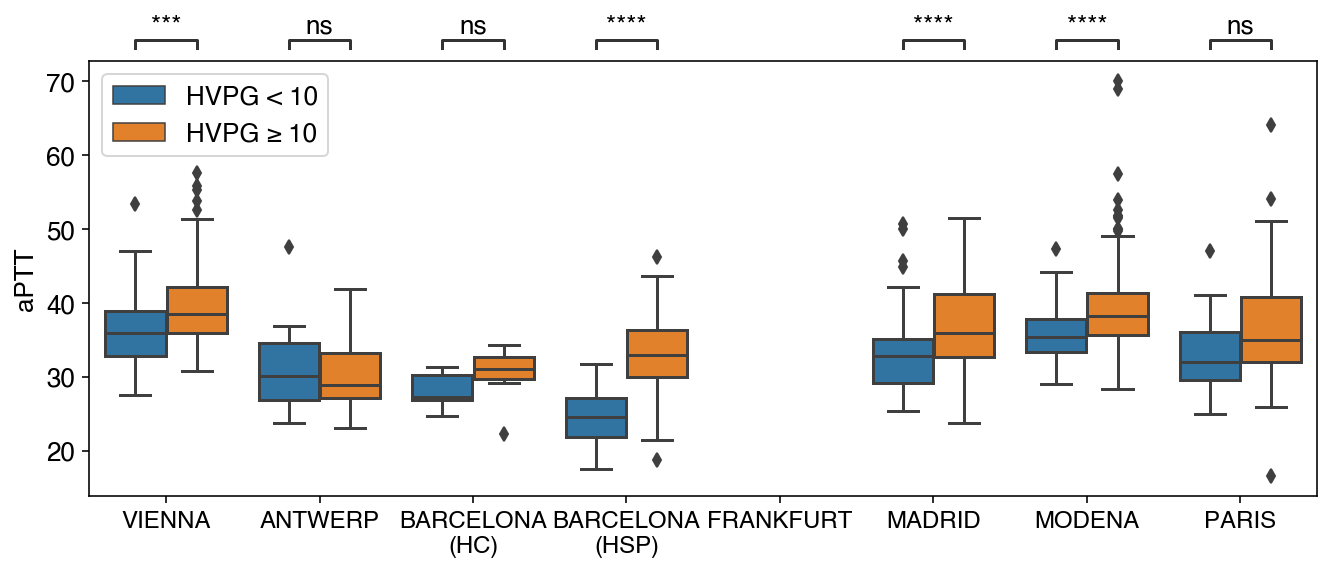

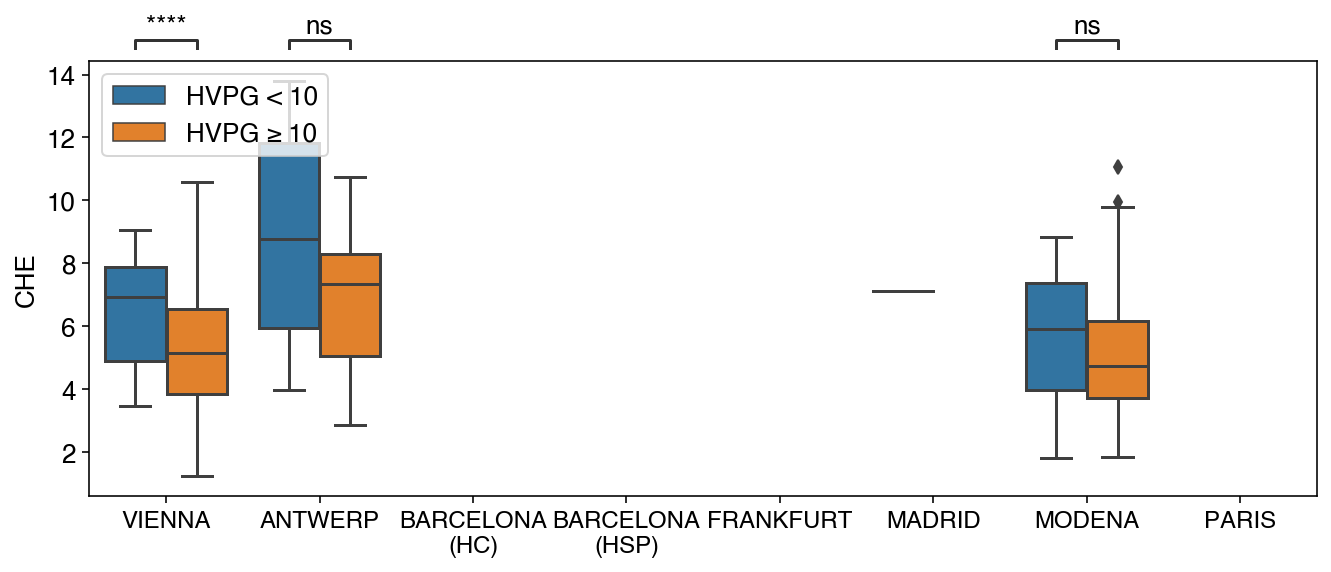

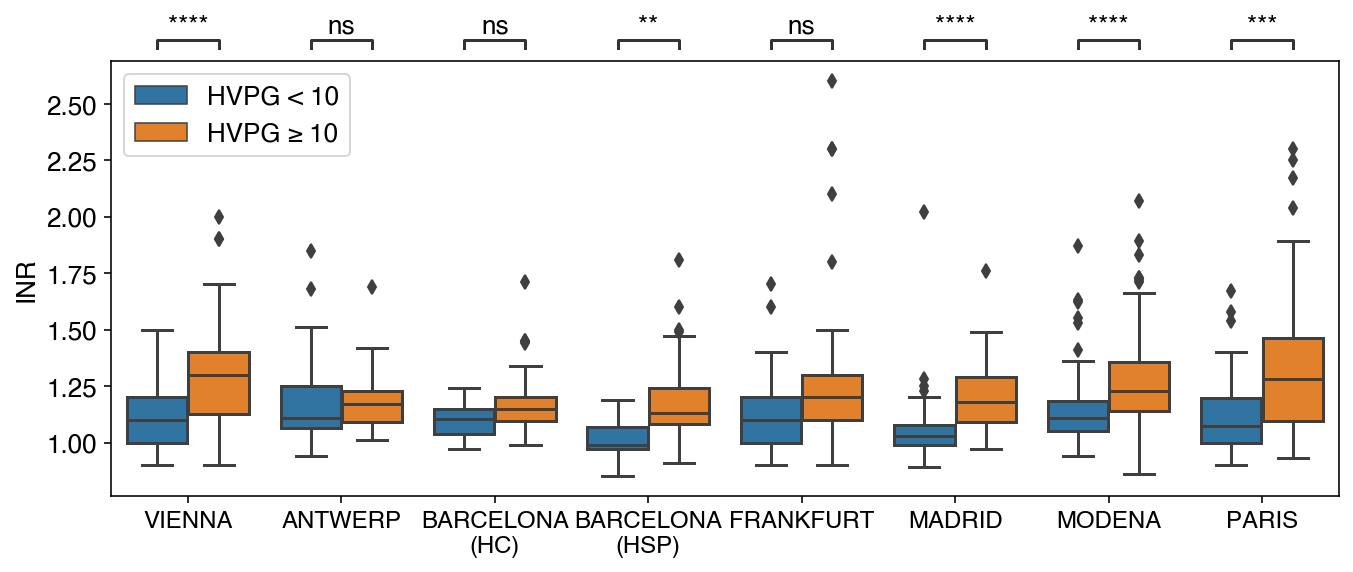

In [38]:
generate_boxplots(10)

### Scatterplots

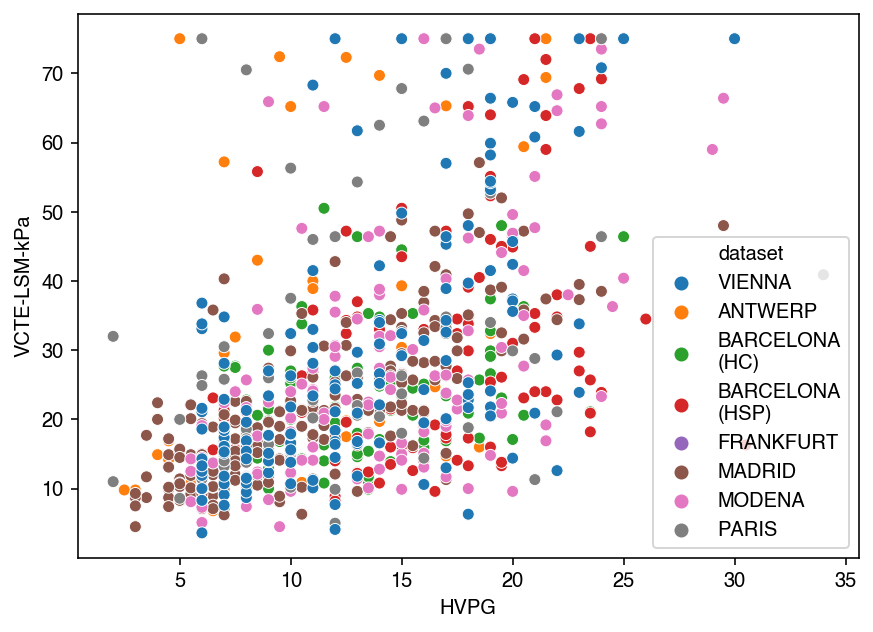

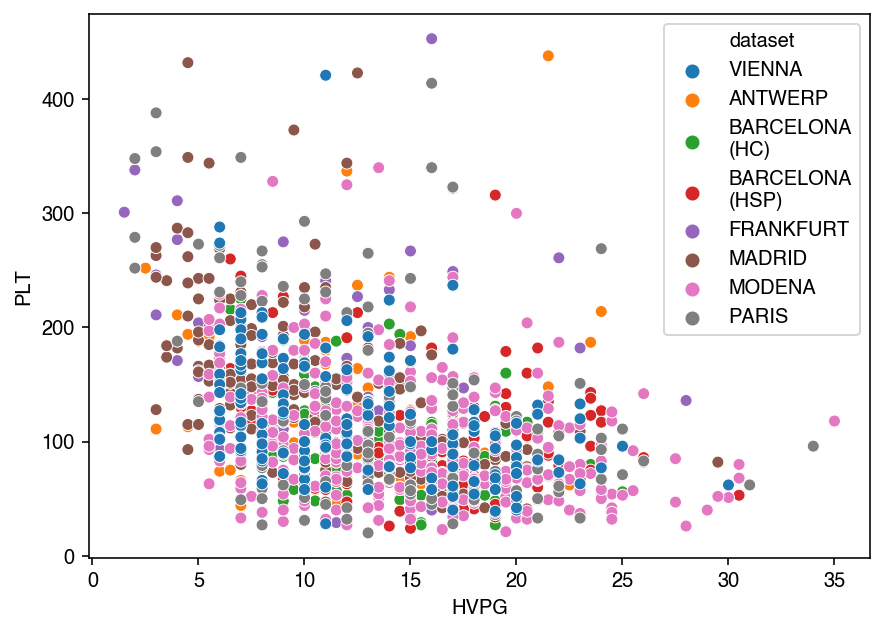

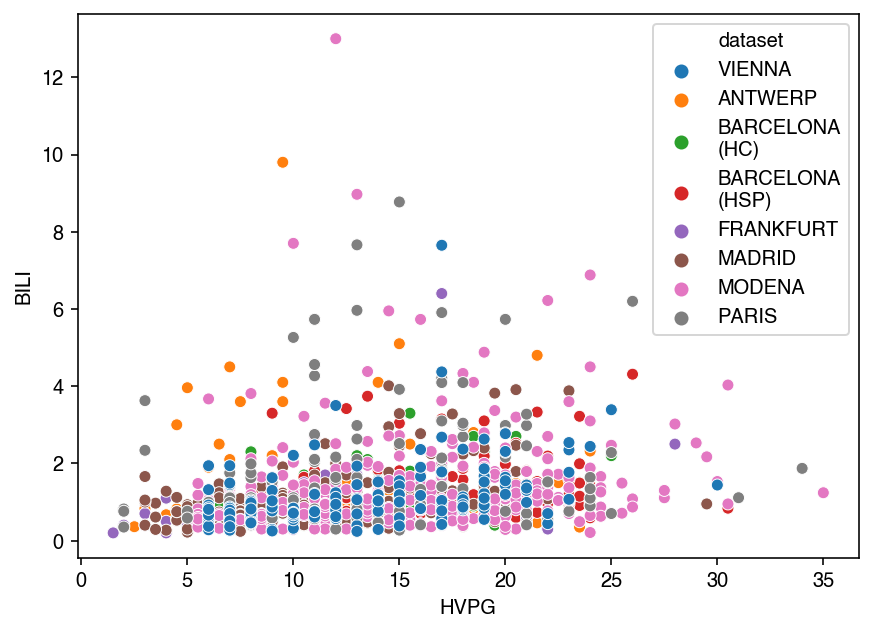

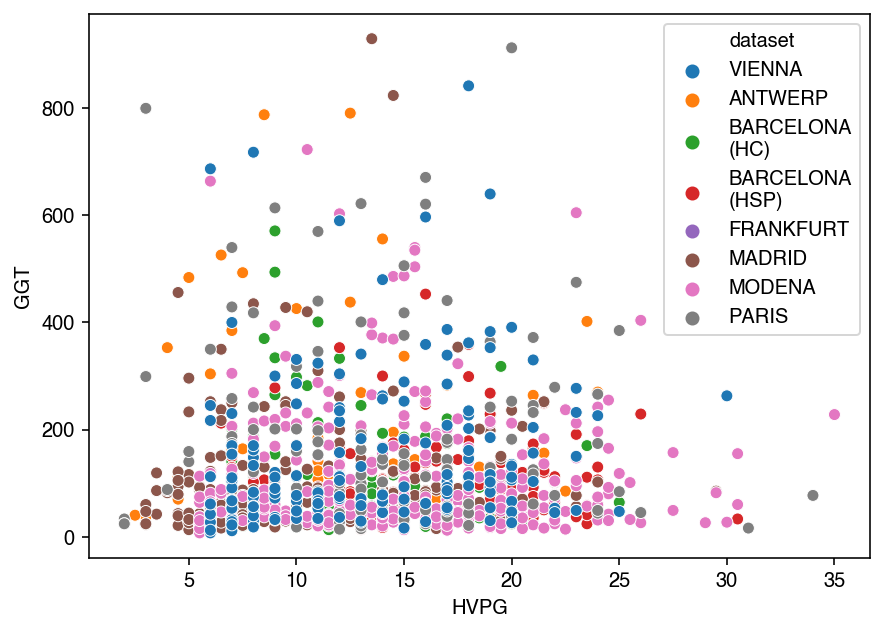

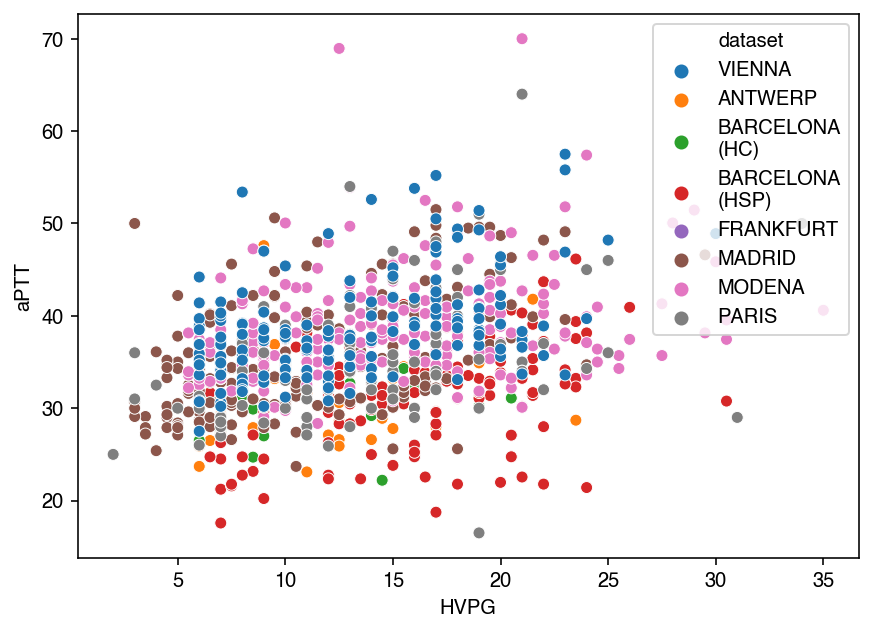

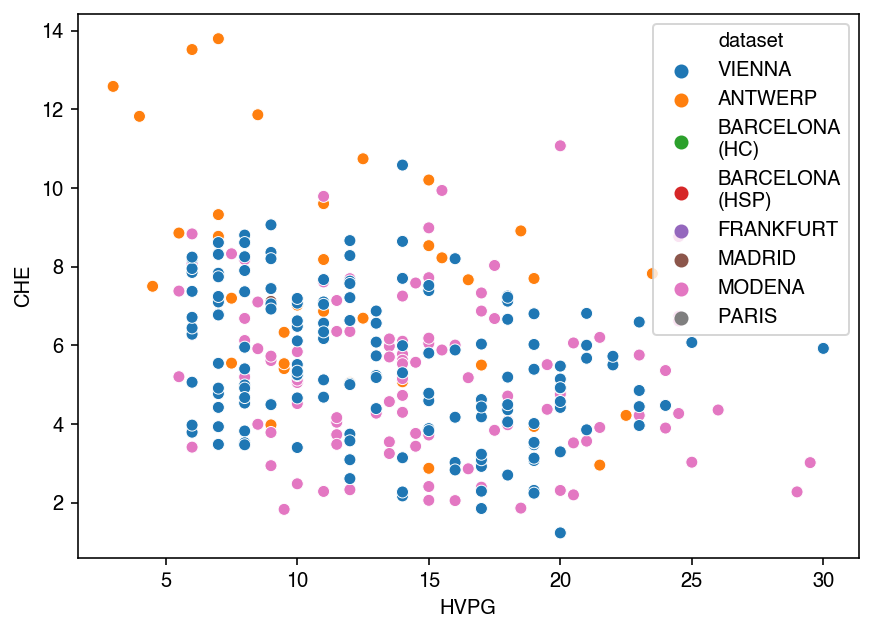

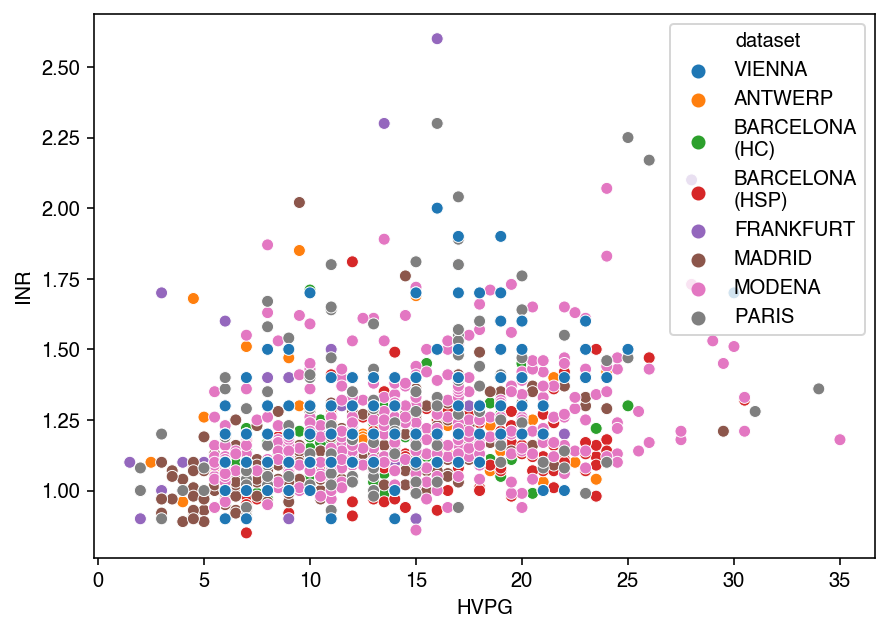

In [39]:
# define comparisons for statistical testing
numeric_parameters = ["VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR"]

for parameter in numeric_parameters:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=data, x="HVPG", y=parameter, hue="dataset")
    
    plt.savefig(f"{plot_folder}/parameters_distributions/{parameter}_vs_HVPG_scatterplot.pdf", bbox_inches="tight")

    plt.show()    